# Experiment on social dynamics for paper by Anton Kolonin: "Cognitive architecture and behavioral model based on social evidence and resource constraints"

Setup: consoder 5 social agents with recreatinal preferences (hobbies) enumeratedd below as A, B, C, X, Y, Z: 

- A — Aikido
- B — Basketball
- C — Cricket
- X — Xare
- Y — Yoga
- Z — Zumba

In [1]:
import os, sys
cwd = os.getcwd()
project_path = cwd[:cwd.find('pygents')+7]
if project_path not in sys.path: sys.path.append(project_path)
os.chdir(project_path)

import matplotlib.pyplot as plt

#force reimport
if 'pygents.util' in sys.modules:
    del sys.modules['pygents.util']
if 'pygents.plot' in sys.modules:
    del sys.modules['pygents.plot']


from pygents.util import cosine_similarity, dict_compress_with_loss
from pygents.plot import matrix_plot


In [79]:
def calc_proximites(agents):
    avg = 0
    cnt = 0
    proximities = {}
    for a1 in agents:
        for a2 in agents:
            if a1 != a2:
                cs = round(cosine_similarity(agents[a1],agents[a2]),2)
                proximities[(a1,a2)] = cs
                avg += cs
                cnt += 1
    return proximities, avg/cnt

def belief_matrix(agents,decimals=2,b_items=None):
    if b_items is None:
        b_items = set()
        for a in agents:
            belif = agents[a]
            for b in belif:
                b_items.add(b) 
        b_items = sorted(list(b_items))
    matrix = []
    for a in agents:
        row = []
        agent = agents[a]
        for b in b_items:
            bi = round(agent[b],decimals) if b in agent else float('nan')
            row.append(bi)
        matrix.append(row)
    return b_items, matrix

def proximites_matrix(agents,proximities,decimals=2):
    matrix = []
    for a1 in agents:
        row = []
        for a2 in agents:
            cs = round(proximities[(a1,a2)],decimals) if (a1,a2) in proximities else float('nan')
            row.append(cs)
        matrix.append(row)
    return matrix

# share belief between the two 
def send_to_peer(agents,a1,a2,proximities,peer_threshold=0):
    sender = agents[a1]
    recevier = agents[a2]
    proximity = proximities[(a1,a2)]
    if proximity < peer_threshold:
        return
    for b_item in sender:
        sender_value = sender[b_item] # sent belief value in b1
        recevier_value = recevier[b_item] if b_item in recevier else 0 # current belief value in b2
        blended_value = (recevier_value + sender_value * proximity) / (1 + proximity)
        recevier[b_item] = blended_value

def print_agents(agents,decimals=2):
    for agent in agents:
        items = agents[agent]
        print(agent,dict([(i,round(items[i],decimals)) for i in sorted(items)]))

def experiment(agents,senders,recalc_proximities=False,peer_threshold=0,printout=True):
    proximities, avg = calc_proximites(agents)
    for a1 in senders:
        for a2 in agents:
            if a1 != a2:
                send_to_peer(agents,a1,a2,proximities,peer_threshold)
                proximities_new, avg = calc_proximites(agents)
                if printout:
                    print(a1,'->',a2,round(avg,2))
                    print_agents(agents)
                    matrix = proximites_matrix(agents,proximities_new)
                    matrix_plot(agents, agents, matrix, 1.0, title = None, vmin = 0, vmax = 1.0, dpi = None, titlefontsize = 20, width = 5)
                if recalc_proximities:
                    proximities = proximities_new


In [80]:
def experiment_with_plots(recalc_proximities, peer_threshold, forgetting_threshold = None, printout = False):
    agents = {
        1 : {'A':1.0,'B':1.0},
        2 : {'A':1.0,'B':1.0},
        3 : {'A':1.0,'B':1.0,'C':1.0,'X':1.0},
        4 : {'X':1.0,'Y':1.0,'Z':1.0},
        5 : {'X':1.0,'Y':1.0},
    }


    fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(10, 4), dpi = 300)
    fig.subplots_adjust(wspace=0.5)

    b_items, b_matrix = belief_matrix(agents,decimals=1)
    proximities, avg = calc_proximites(agents)
    matrix = proximites_matrix(agents,proximities,decimals=1)
    print('Start',round(avg,2))
    print_agents(agents)

    sns.heatmap(b_matrix, xticklabels=b_items, yticklabels=agents.keys(), vmin = 0.0, vmax = 1.0, 
                        cmap='RdYlGn', annot=True, ax=axs[0][0], cbar=False)
    axs[0][0].set_title("Agent Beliefs, Initial")

    sns.heatmap(matrix, xticklabels=agents.keys(), yticklabels=agents.keys(), vmin = 0.0, vmax = 1.0, 
                        cmap='RdYlGn', annot=True, ax=axs[1][0], cbar=False)
    axs[1][0].set_title("Agent Proximities, Initial")

    for i in range(3):
        experiment(agents,agents,recalc_proximities=recalc_proximities,peer_threshold = peer_threshold, printout = False)
        if not forgetting_threshold is None:
            for a in agents:
                agents[a] = dict_compress_with_loss(agents[a],forgetting_threshold)

        b_items, b_matrix = belief_matrix(agents,decimals=1,b_items=b_items)
        proximities, avg = calc_proximites(agents)
        matrix = proximites_matrix(agents,proximities,decimals=1)

        sns.heatmap(b_matrix, xticklabels=b_items, yticklabels=agents.keys(), vmin = 0.0, vmax = 1.0, 
                            cmap='RdYlGn', annot=True, ax=axs[0][i+1], cbar=(i==3-1))
        axs[0][i+1].set_title(f"Belief Items, {i+1}")

        sns.heatmap(matrix, xticklabels=agents.keys(), yticklabels=agents.keys(), vmin = 0.0, vmax = 1.0, 
                            cmap='RdYlGn', annot=True, ax=axs[1][i+1], cbar=(i==3-1))
        axs[1][i+1].set_title(f"Belief Proximities, {i+1}")

        #matrix_plot(agents, agents, matrix, 1.0, title = None, vmin = 0, vmax = 1.0, dpi = None, titlefontsize = 20, width = 4)
        print_agents(agents)
        print(round(avg,2))

    fig.tight_layout(pad=1.0)
    plt.show()


1 {'A': 1.0, 'B': 1.0}
2 {'A': 1.0, 'B': 1.0}
3 {'A': 1.0, 'B': 1.0, 'C': 1.0, 'X': 1.0}
4 {'X': 1.0, 'Y': 1.0, 'Z': 1.0}
5 {'X': 1.0, 'Y': 1.0}


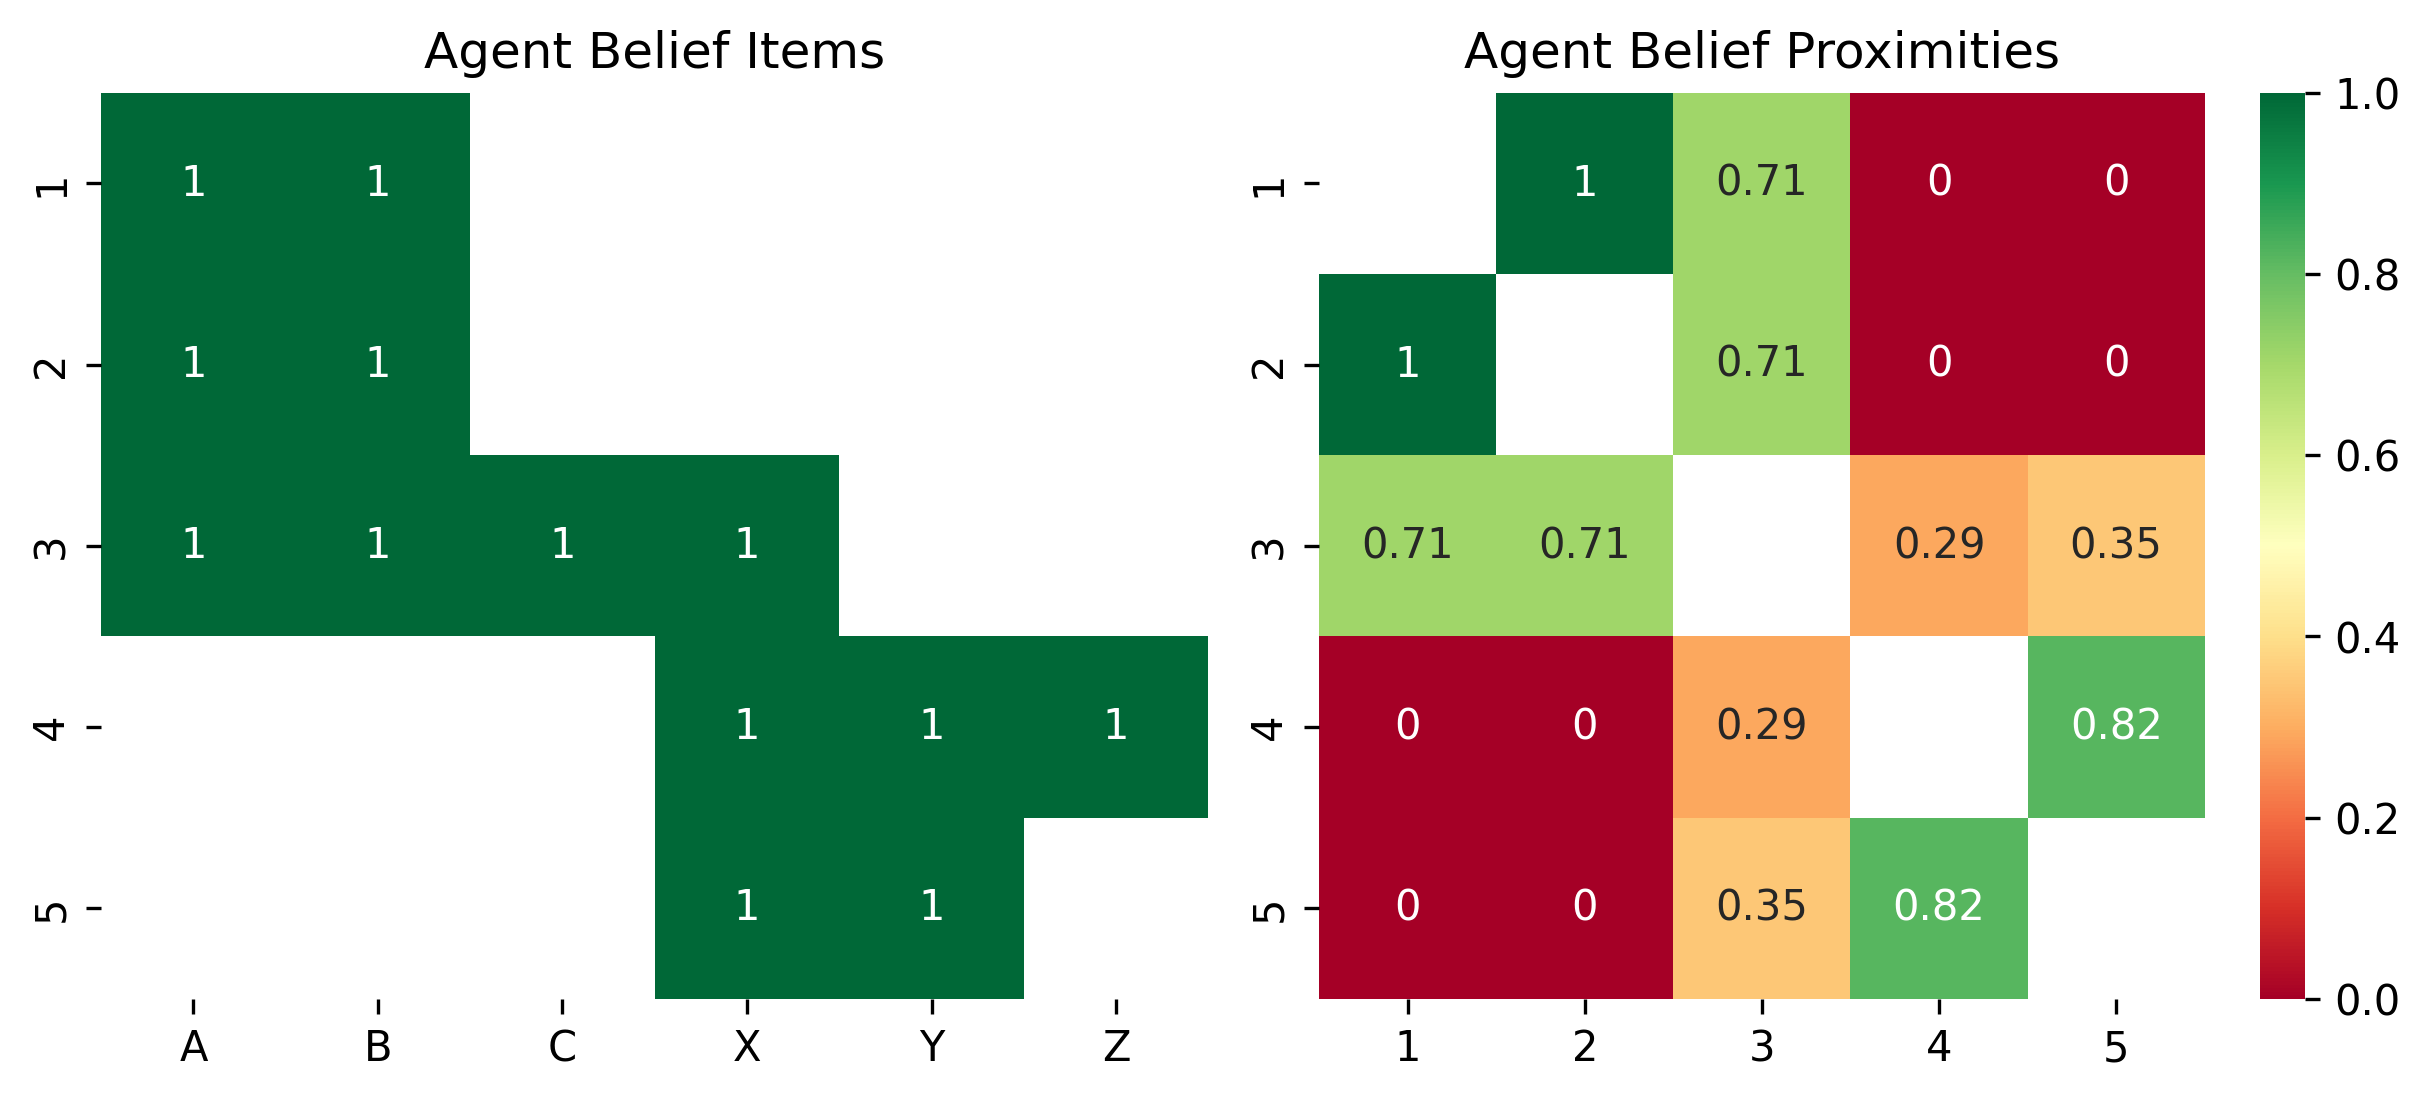

In [81]:
agents = {
    1 : {'A':1.0,'B':1.0},
    2 : {'A':1.0,'B':1.0},
    3 : {'A':1.0,'B':1.0,'C':1.0,'X':1.0},
    4 : {'X':1.0,'Y':1.0,'Z':1.0},
    5 : {'X':1.0,'Y':1.0},
}

b_items, b_matrix = belief_matrix(agents)
proximities, avg = calc_proximites(agents)
matrix = proximites_matrix(agents,proximities)
print_agents(agents)

#matrix_plot(agents, b_items, b_matrix, 1.0, title = None, vmin = 0, vmax = 1.0, dpi = None, titlefontsize = 20, width = 3)
#matrix_plot(agents, agents, matrix, 1.0, title = None, vmin = 0, vmax = 1.0, dpi = None, titlefontsize = 20, width = 3)

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 4), dpi = 300)
fig.subplots_adjust(wspace=0.1)

sns.heatmap(b_matrix, xticklabels=b_items, yticklabels=agents.keys(), vmin = 0.0, vmax = 1.0, 
                    cmap='RdYlGn', annot=True, ax=axs[0], cbar=False)
axs[0].set_title("Agent Belief Items")

sns.heatmap(matrix, xticklabels=agents.keys(), yticklabels=agents.keys(), vmin = 0.0, vmax = 1.0, 
                    cmap='RdYlGn', annot=True, ax=axs[1], cbar=True)
axs[1].set_title("Agent Belief Proximities")
plt.show()

Start 0.39
1 {'A': 1.0, 'B': 1.0}
2 {'A': 1.0, 'B': 1.0}
3 {'A': 1.0, 'B': 1.0, 'C': 1.0, 'X': 1.0}
4 {'X': 1.0, 'Y': 1.0, 'Z': 1.0}
5 {'X': 1.0, 'Y': 1.0}
1 {'A': 0.58, 'B': 0.58, 'C': 0.32, 'X': 0.74, 'Y': 0.56, 'Z': 0.34}
2 {'A': 0.58, 'B': 0.58, 'C': 0.32, 'X': 0.74, 'Y': 0.56, 'Z': 0.34}
3 {'A': 0.53, 'B': 0.53, 'C': 0.53, 'X': 1.0, 'Y': 0.62, 'Z': 0.38}
4 {'A': 0.23, 'B': 0.23, 'C': 0.23, 'X': 1.0, 'Y': 1.0, 'Z': 0.73}
5 {'A': 0.24, 'B': 0.24, 'C': 0.24, 'X': 1.0, 'Y': 1.0, 'Z': 0.45}
0.93
1 {'A': 0.54, 'B': 0.54, 'C': 0.34, 'X': 0.8, 'Y': 0.61, 'Z': 0.37}
2 {'A': 0.54, 'B': 0.54, 'C': 0.34, 'X': 0.8, 'Y': 0.61, 'Z': 0.37}
3 {'A': 0.53, 'B': 0.53, 'C': 0.34, 'X': 0.81, 'Y': 0.61, 'Z': 0.37}
4 {'A': 0.52, 'B': 0.52, 'C': 0.33, 'X': 0.81, 'Y': 0.62, 'Z': 0.39}
5 {'A': 0.52, 'B': 0.52, 'C': 0.33, 'X': 0.81, 'Y': 0.62, 'Z': 0.38}
1.0
1 {'A': 0.53, 'B': 0.53, 'C': 0.34, 'X': 0.8, 'Y': 0.61, 'Z': 0.37}
2 {'A': 0.53, 'B': 0.53, 'C': 0.34, 'X': 0.8, 'Y': 0.61, 'Z': 0.37}
3 {'A': 0.53, 'B

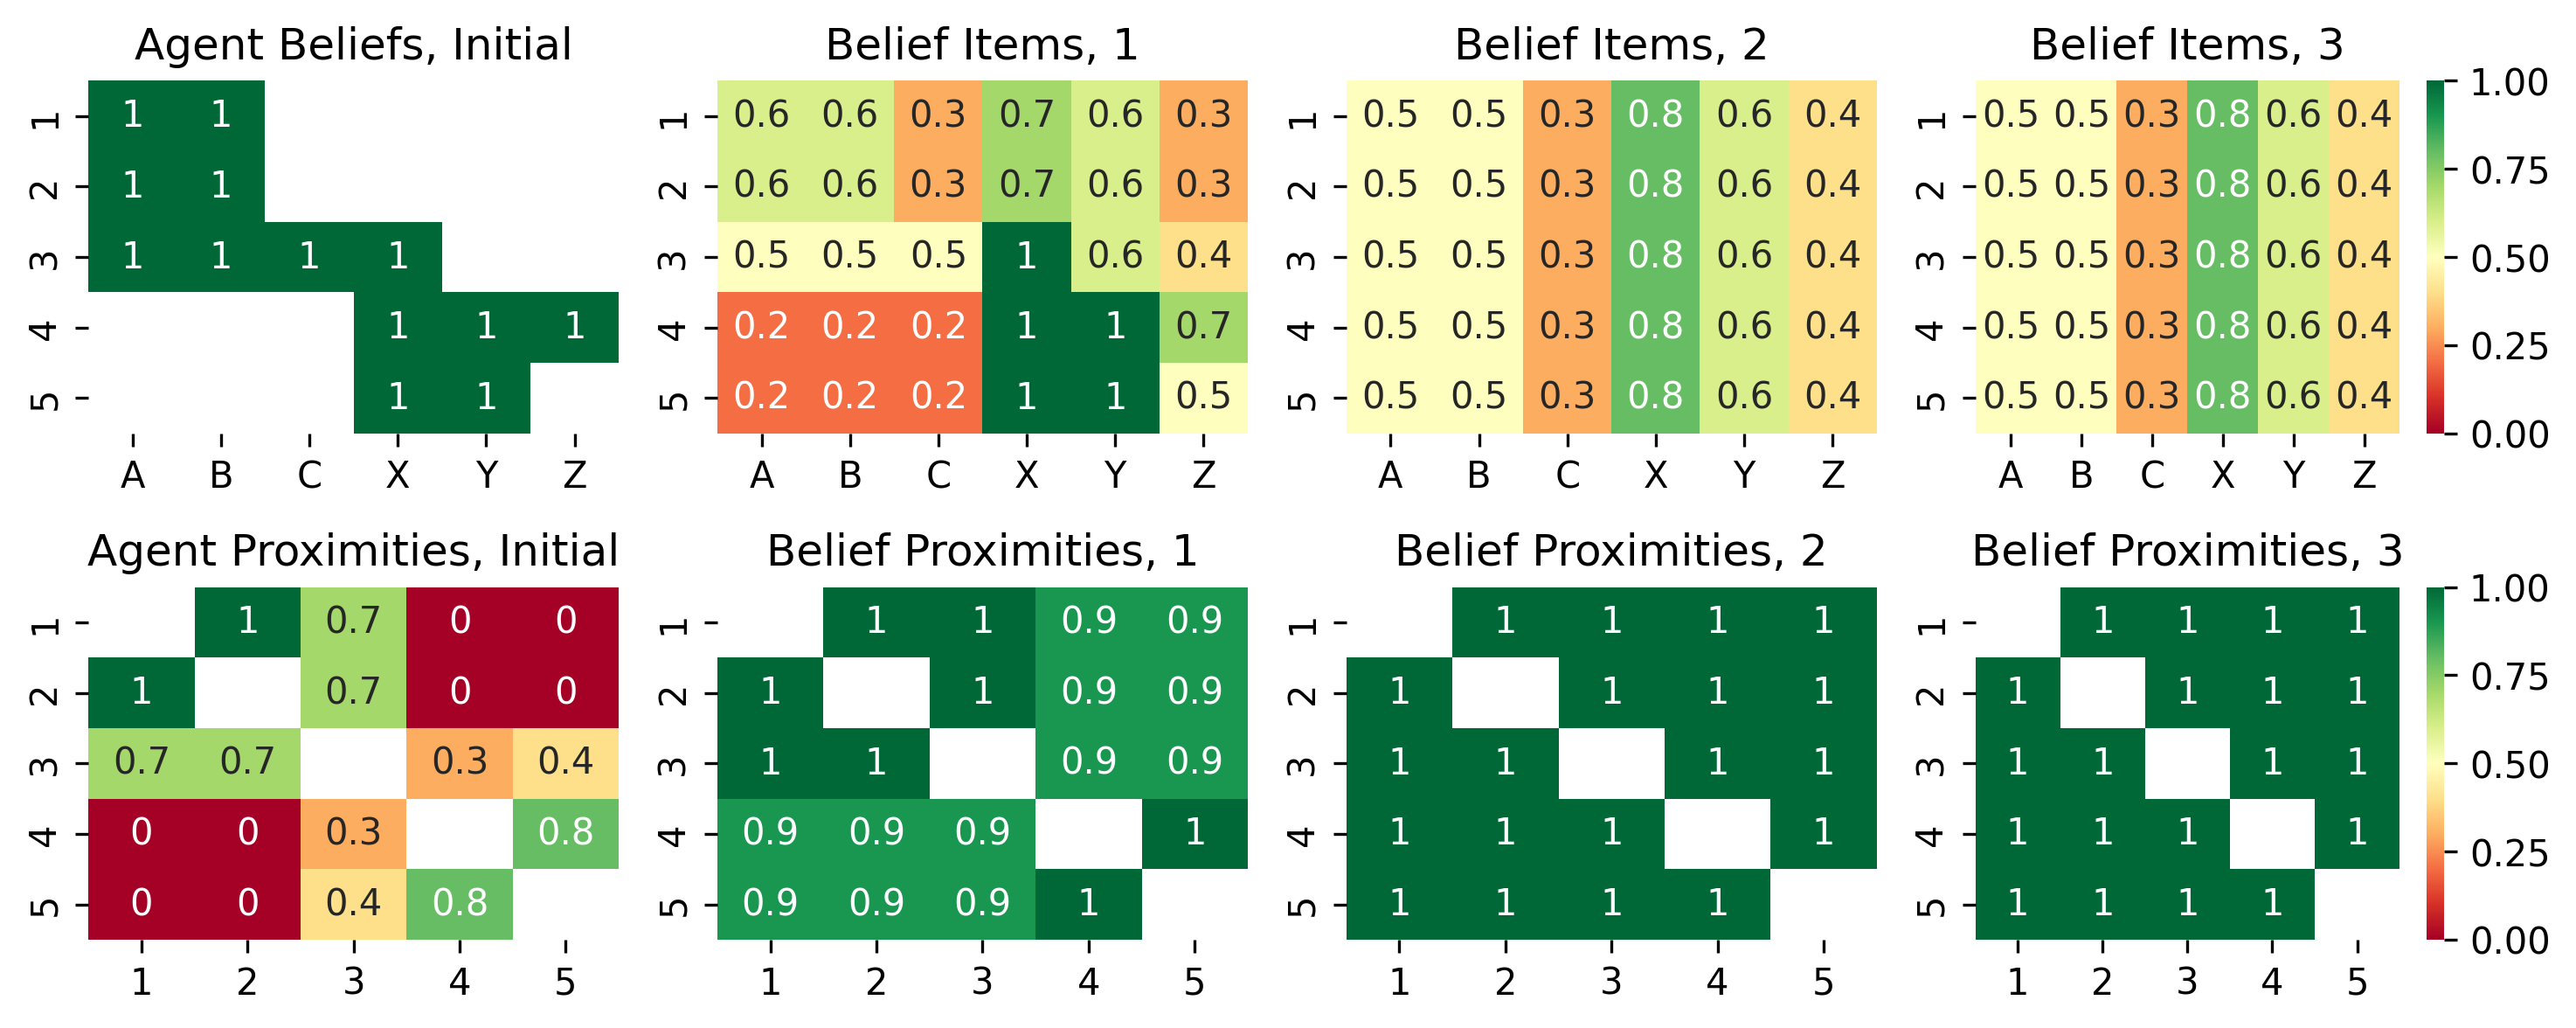

In [82]:
# socially open, open belief (frequent proximity updates, dynamic social proximity) => diverse unification quickly
# 0.39->0.93
experiment_with_plots(recalc_proximities=True, peer_threshold = 0.0, printout = False)


Start 0.39
1 {'A': 1.0, 'B': 1.0}
2 {'A': 1.0, 'B': 1.0}
3 {'A': 1.0, 'B': 1.0, 'C': 1.0, 'X': 1.0}
4 {'X': 1.0, 'Y': 1.0, 'Z': 1.0}
5 {'X': 1.0, 'Y': 1.0}
1 {'A': 1.0, 'B': 1.0, 'C': 0.42, 'X': 0.42, 'Y': 0.0, 'Z': 0.0}
2 {'A': 1.0, 'B': 1.0, 'C': 0.42, 'X': 0.42, 'Y': 0.0, 'Z': 0.0}
3 {'A': 0.67, 'B': 0.67, 'C': 0.67, 'X': 1.0, 'Y': 0.43, 'Z': 0.28}
4 {'A': 0.23, 'B': 0.23, 'C': 0.23, 'X': 1.0, 'Y': 1.0, 'Z': 0.75}
5 {'A': 0.24, 'B': 0.24, 'C': 0.24, 'X': 1.0, 'Y': 1.0, 'Z': 0.45}
0.69
1 {'A': 0.85, 'B': 0.85, 'C': 0.43, 'X': 0.58, 'Y': 0.2, 'Z': 0.13}
2 {'A': 0.85, 'B': 0.85, 'C': 0.43, 'X': 0.58, 'Y': 0.2, 'Z': 0.13}
3 {'A': 0.79, 'B': 0.79, 'C': 0.43, 'X': 0.64, 'Y': 0.28, 'Z': 0.18}
4 {'A': 0.74, 'B': 0.74, 'C': 0.4, 'X': 0.66, 'Y': 0.34, 'Z': 0.23}
5 {'A': 0.74, 'B': 0.74, 'C': 0.4, 'X': 0.66, 'Y': 0.34, 'Z': 0.21}
0.99
1 {'A': 0.83, 'B': 0.83, 'C': 0.42, 'X': 0.59, 'Y': 0.22, 'Z': 0.15}
2 {'A': 0.83, 'B': 0.83, 'C': 0.42, 'X': 0.59, 'Y': 0.22, 'Z': 0.15}
3 {'A': 0.83, 'B': 0.83

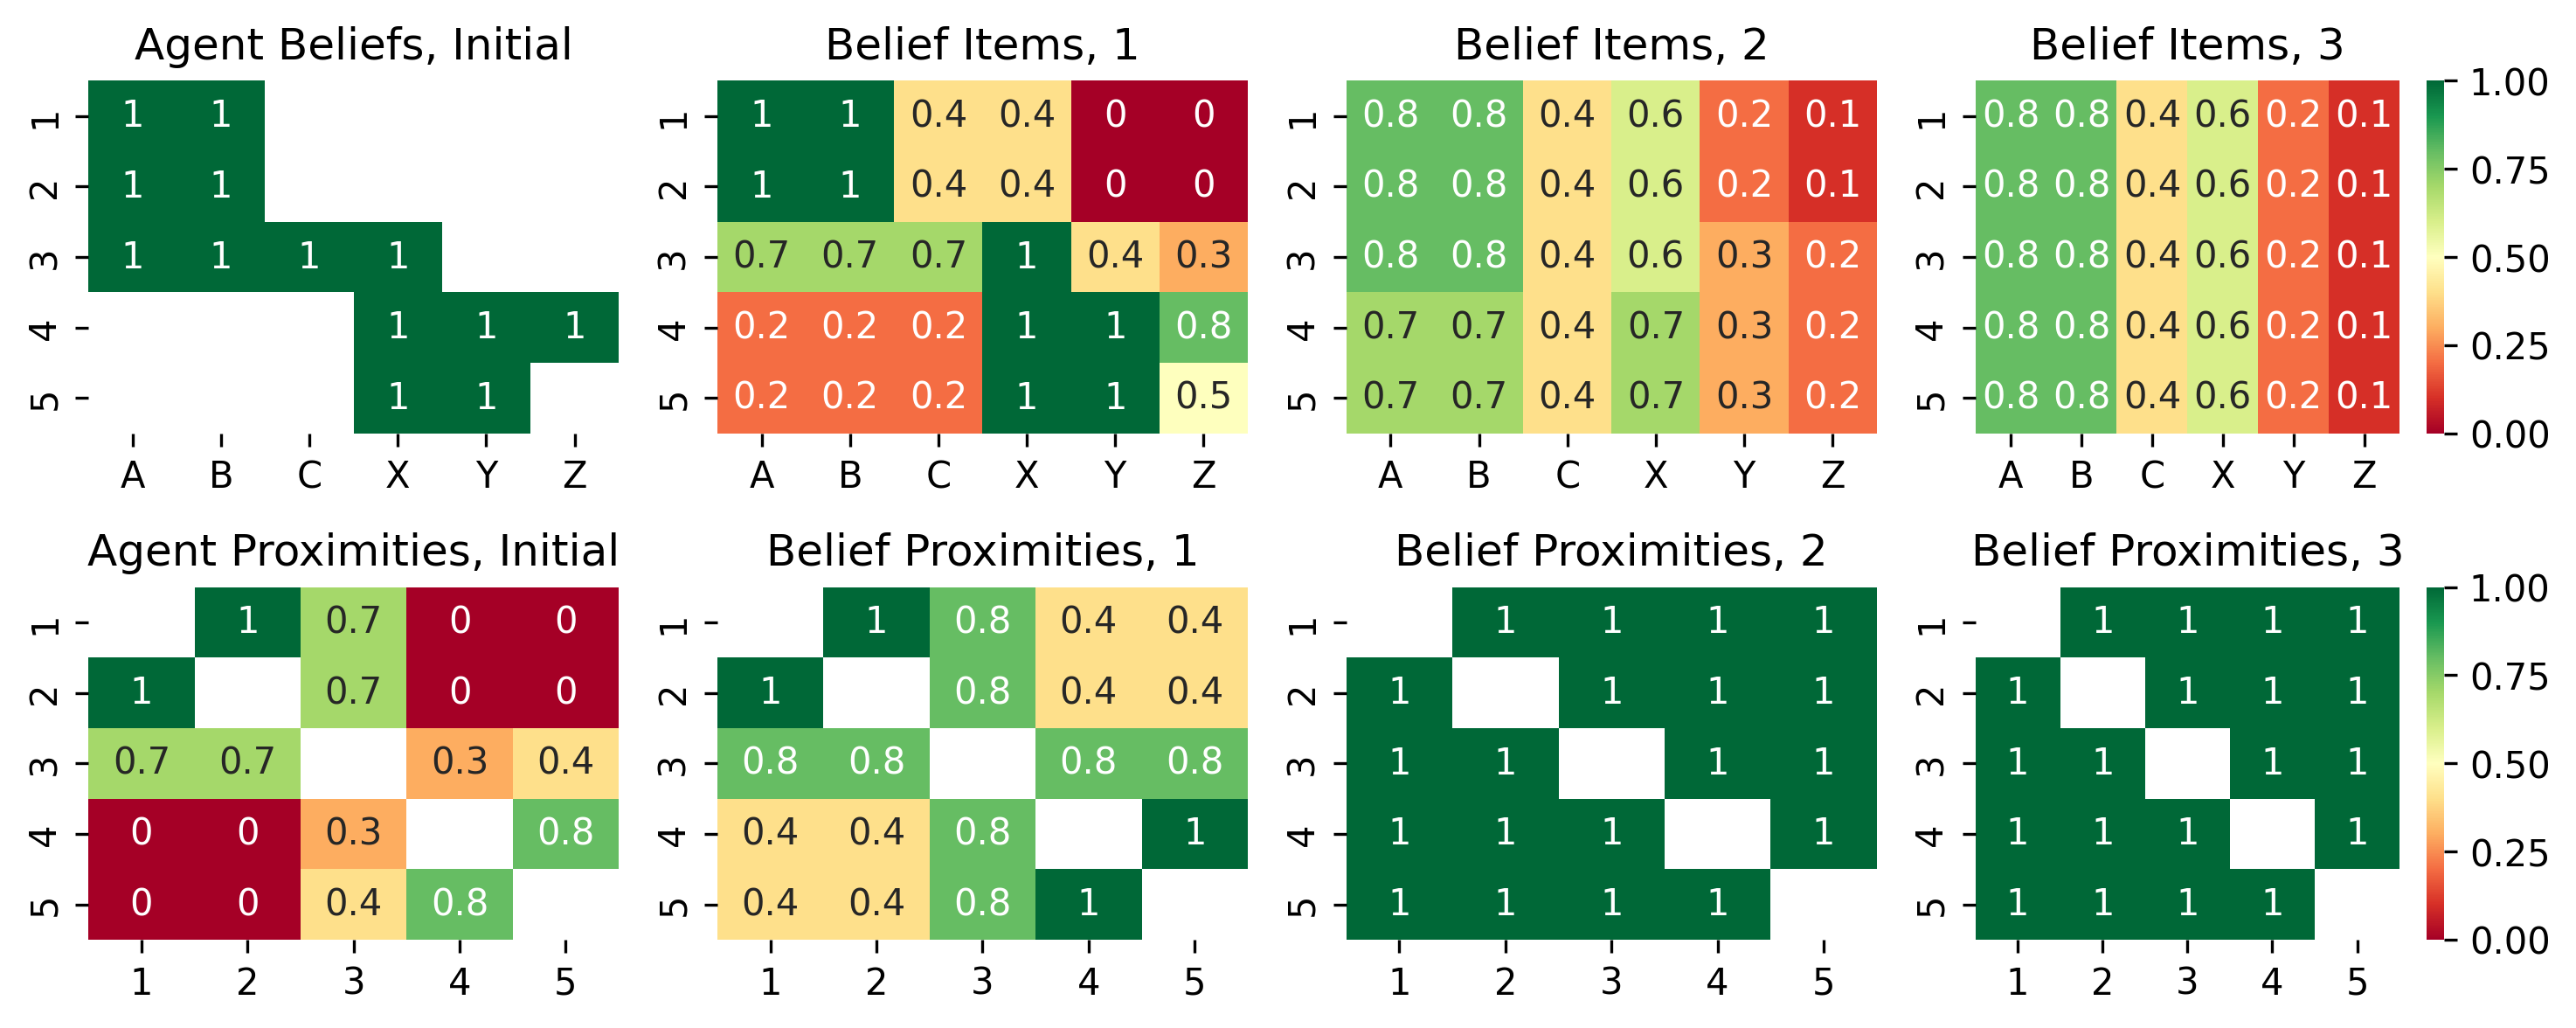

In [83]:
# socially open, open belief (rare proximity updates, static social proximity) => diverse unification slowly      
# 0.39->0.69
experiment_with_plots(recalc_proximities=False, peer_threshold = 0.0, printout = False)


Start 0.39
1 {'A': 1.0, 'B': 1.0}
2 {'A': 1.0, 'B': 1.0}
3 {'A': 1.0, 'B': 1.0, 'C': 1.0, 'X': 1.0}
4 {'X': 1.0, 'Y': 1.0, 'Z': 1.0}
5 {'X': 1.0, 'Y': 1.0}
1 {'A': 1.0, 'B': 1.0, 'C': 0.42, 'X': 0.42}
2 {'A': 1.0, 'B': 1.0, 'C': 0.42, 'X': 0.42}
3 {'A': 1.0, 'B': 1.0, 'C': 1.0, 'X': 1.0}
4 {'X': 1.0, 'Y': 1.0, 'Z': 0.73}
5 {'X': 1.0, 'Y': 1.0, 'Z': 0.45}
0.52
1 {'A': 1.0, 'B': 1.0, 'C': 0.49, 'X': 0.49}
2 {'A': 1.0, 'B': 1.0, 'C': 0.49, 'X': 0.49}
3 {'A': 1.0, 'B': 1.0, 'C': 0.57, 'X': 0.57}
4 {'X': 1.0, 'Y': 1.0, 'Z': 0.66}
5 {'X': 1.0, 'Y': 1.0, 'Z': 0.59}
0.52
1 {'A': 1.0, 'B': 1.0, 'C': 0.5, 'X': 0.5}
2 {'A': 1.0, 'B': 1.0, 'C': 0.5, 'X': 0.5}
3 {'A': 1.0, 'B': 1.0, 'C': 0.51, 'X': 0.51}
4 {'X': 1.0, 'Y': 1.0, 'Z': 0.64}
5 {'X': 1.0, 'Y': 1.0, 'Z': 0.63}
0.52


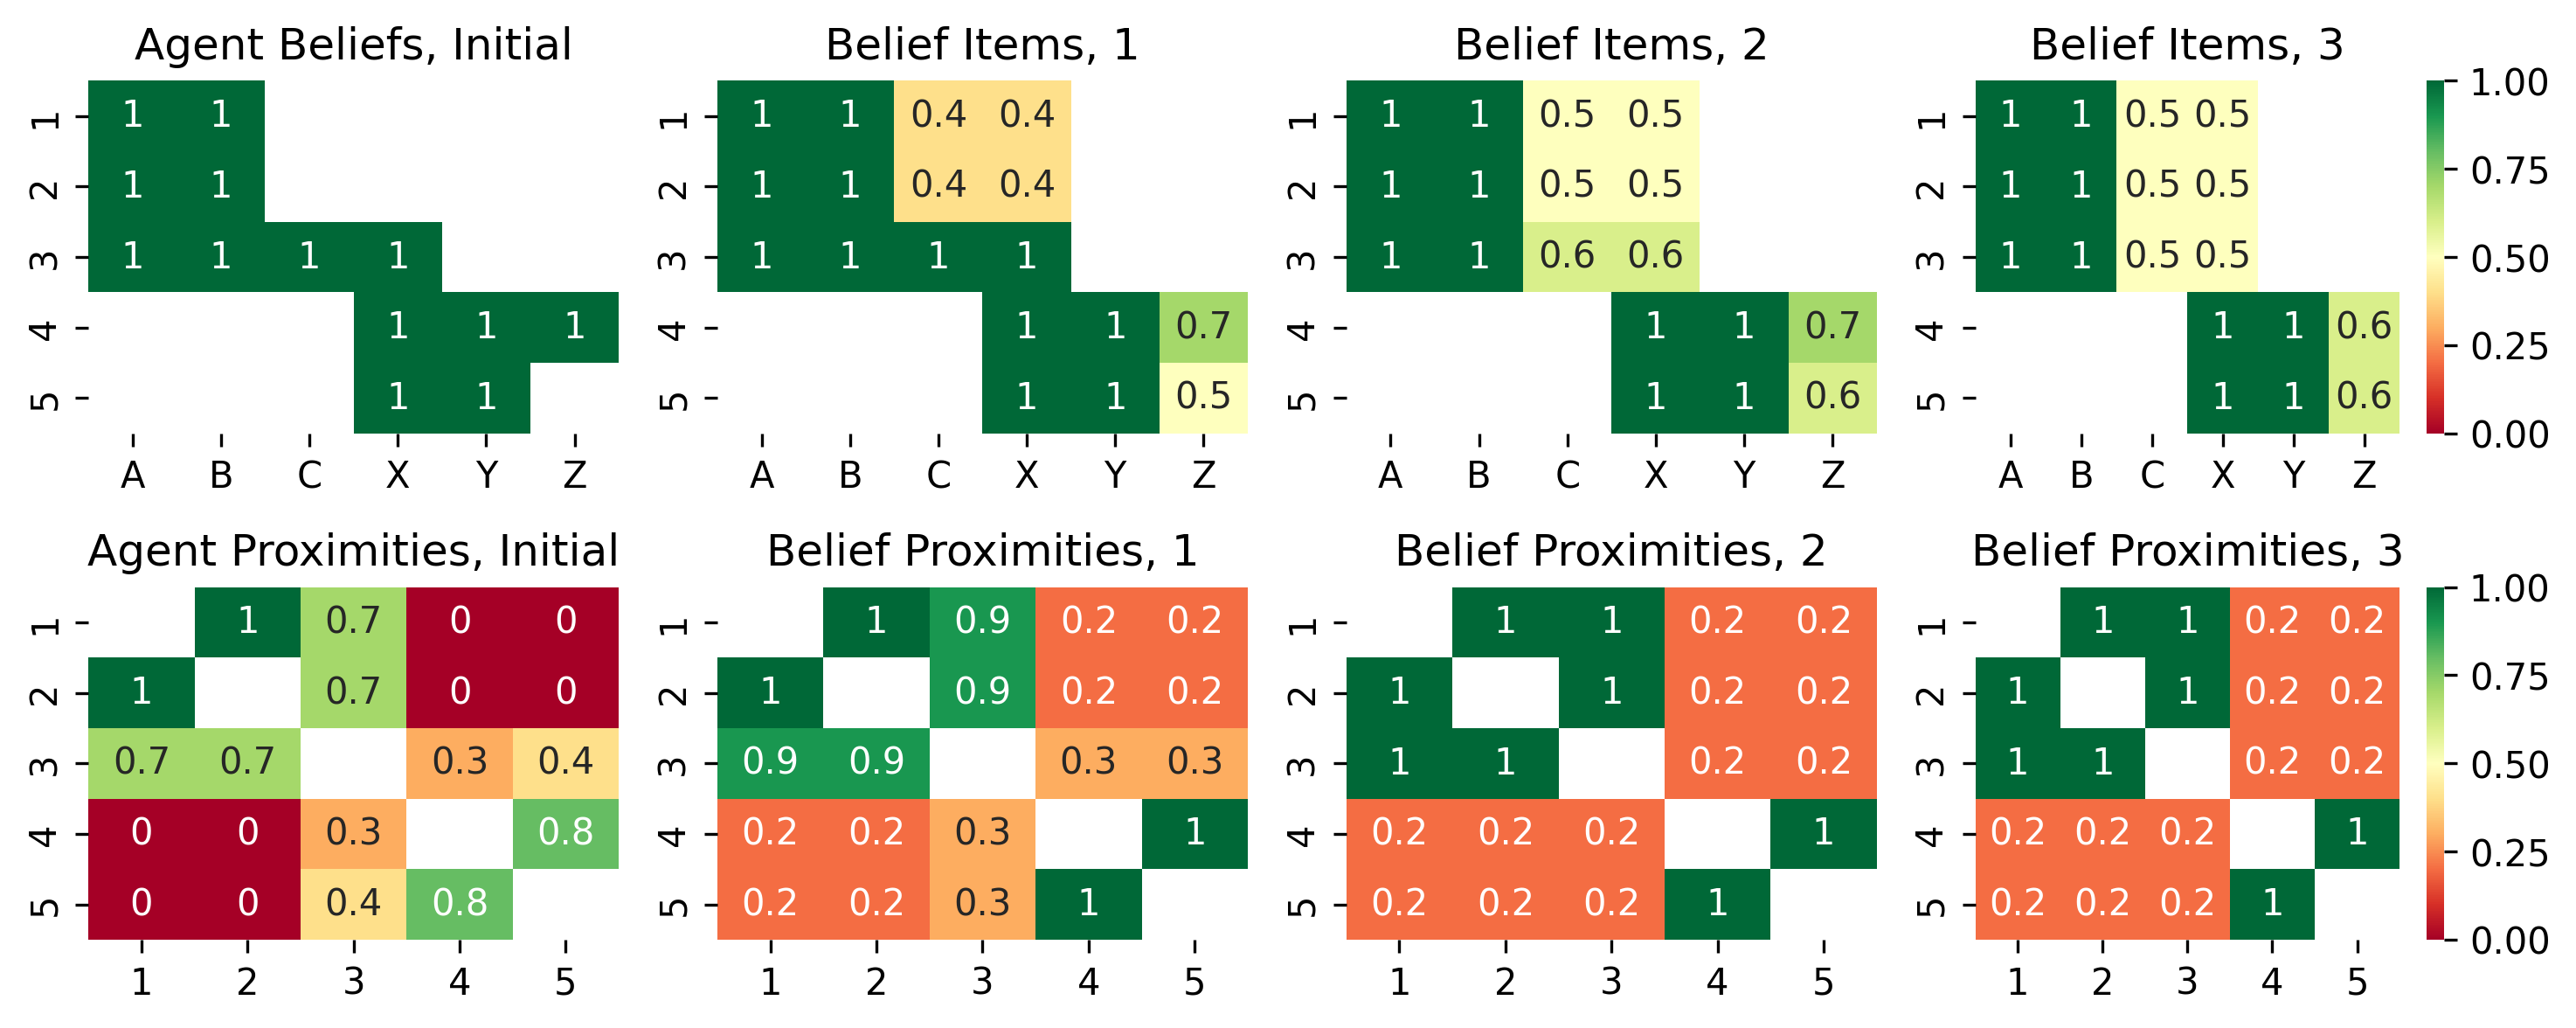

In [84]:
# socially closed, open belief (frequent proximity updates, dynamic social proximity) => polarization 
experiment_with_plots(recalc_proximities=True, peer_threshold = 0.5, printout = False)


Start 0.39
1 {'A': 1.0, 'B': 1.0}
2 {'A': 1.0, 'B': 1.0}
3 {'A': 1.0, 'B': 1.0, 'C': 1.0, 'X': 1.0}
4 {'X': 1.0, 'Y': 1.0, 'Z': 1.0}
5 {'X': 1.0, 'Y': 1.0}
1 {'A': 1.0, 'B': 1.0, 'C': 0.42, 'X': 0.42}
2 {'A': 1.0, 'B': 1.0, 'C': 0.42, 'X': 0.42}
3 {'A': 1.0, 'B': 1.0, 'C': 1.0, 'X': 1.0}
4 {'X': 1.0, 'Y': 1.0, 'Z': 0.75}
5 {'X': 1.0, 'Y': 1.0, 'Z': 0.45}
0.52
1 {'A': 1.0, 'B': 1.0, 'C': 0.49, 'X': 0.49}
2 {'A': 1.0, 'B': 1.0, 'C': 0.49, 'X': 0.49}
3 {'A': 1.0, 'B': 1.0, 'C': 0.57, 'X': 0.57}
4 {'X': 1.0, 'Y': 1.0, 'Z': 0.68}
5 {'X': 1.0, 'Y': 1.0, 'Z': 0.6}
0.52
1 {'A': 1.0, 'B': 1.0, 'C': 0.5, 'X': 0.5}
2 {'A': 1.0, 'B': 1.0, 'C': 0.5, 'X': 0.5}
3 {'A': 1.0, 'B': 1.0, 'C': 0.51, 'X': 0.51}
4 {'X': 1.0, 'Y': 1.0, 'Z': 0.66}
5 {'X': 1.0, 'Y': 1.0, 'Z': 0.64}
0.52


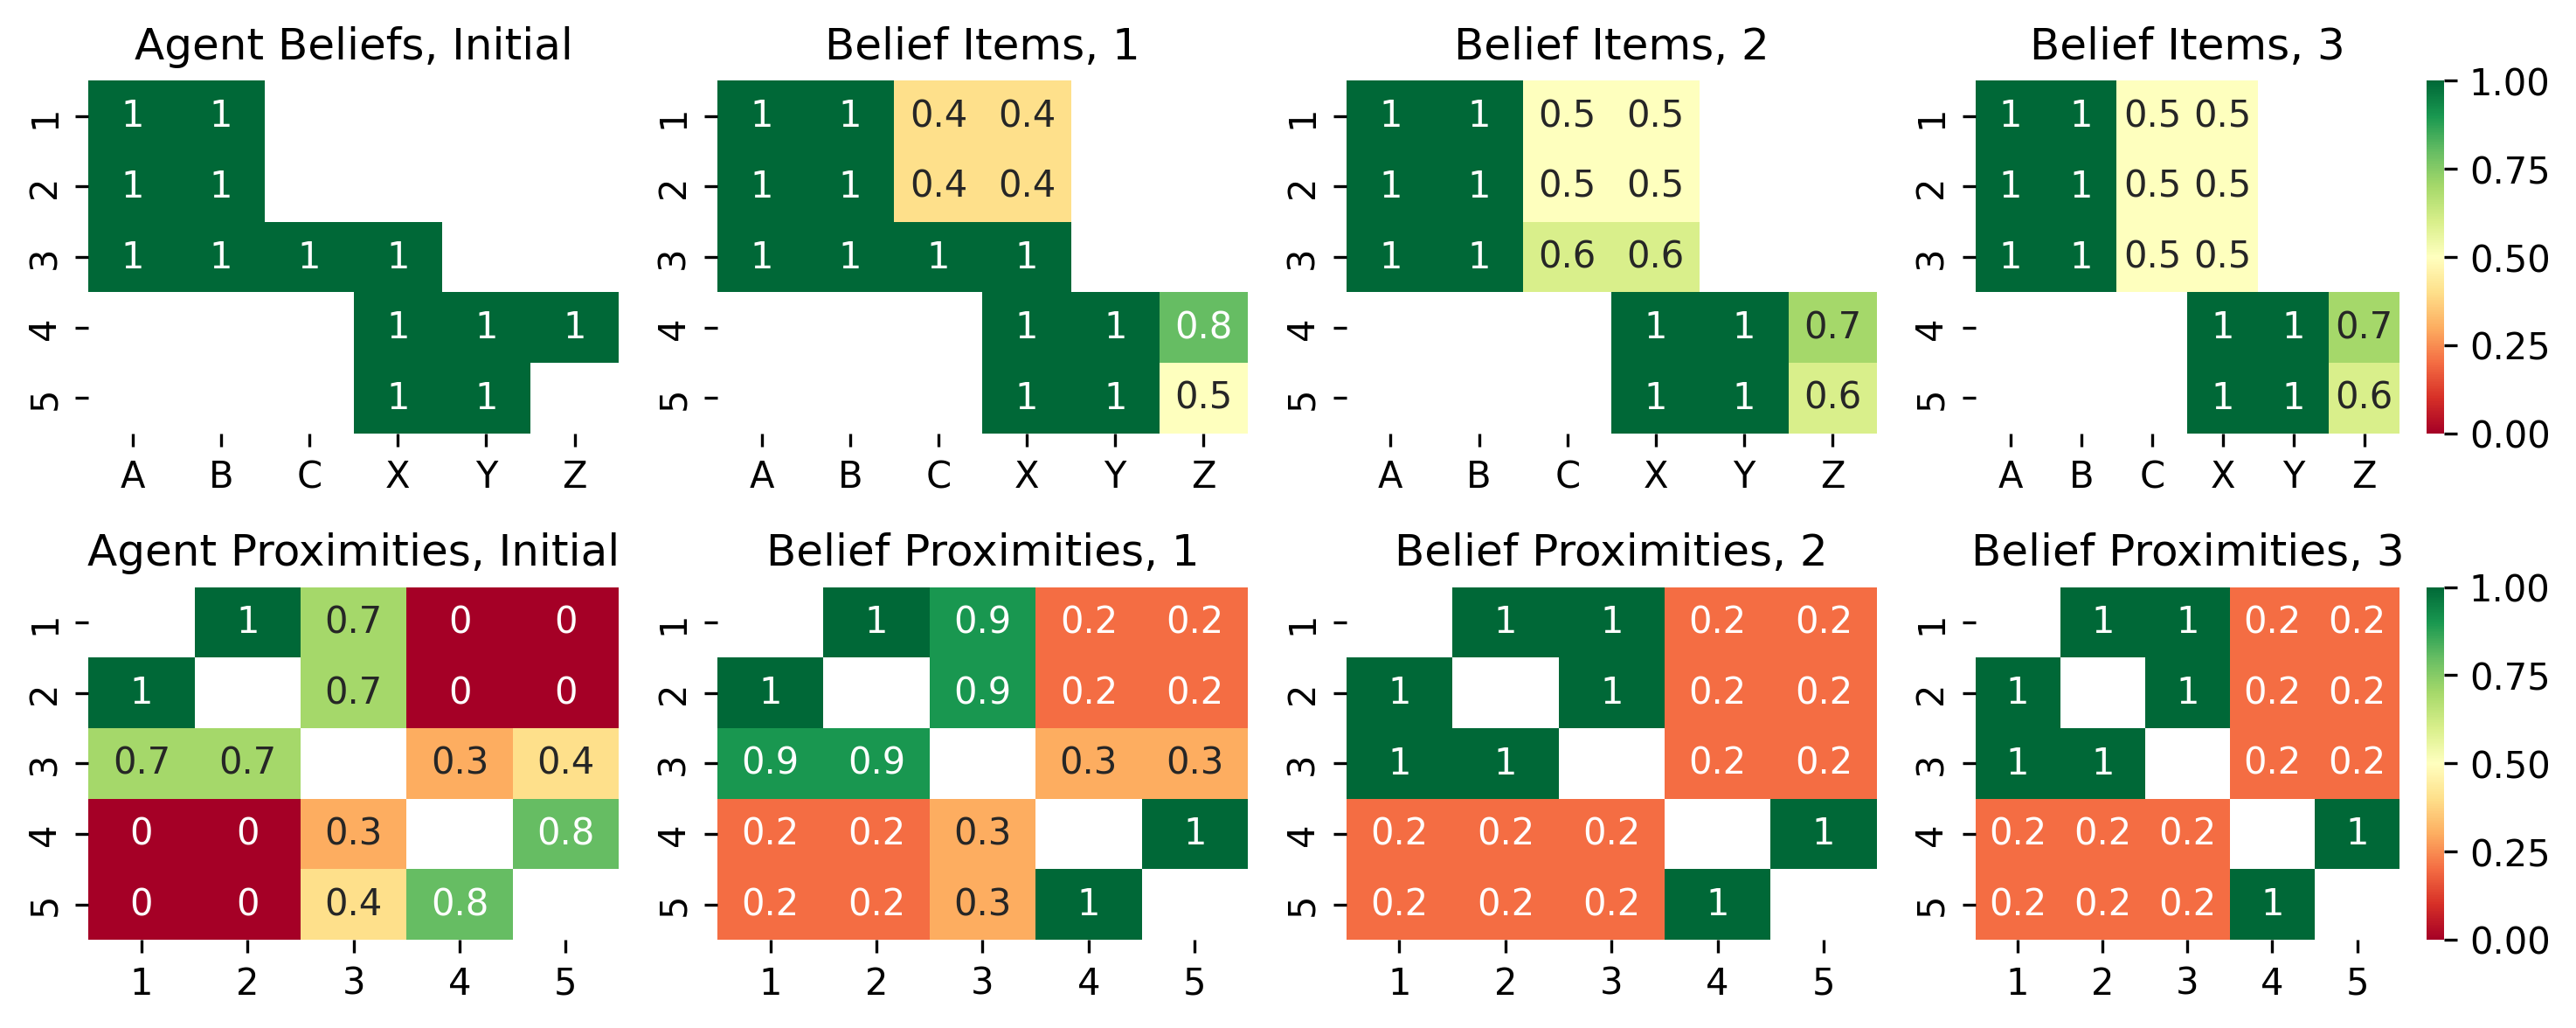

In [85]:
# socially closed, open belief (rare proximity updates, static social proximity) => polarization
experiment_with_plots(recalc_proximities=False, peer_threshold = 0.5, printout = False)


Start 0.39
1 {'A': 1.0, 'B': 1.0}
2 {'A': 1.0, 'B': 1.0}
3 {'A': 1.0, 'B': 1.0, 'C': 1.0, 'X': 1.0}
4 {'X': 1.0, 'Y': 1.0, 'Z': 1.0}
5 {'X': 1.0, 'Y': 1.0}
1 {'A': 1.0, 'B': 1.0}
2 {'A': 1.0, 'B': 1.0}
3 {'A': 1.0, 'B': 1.0, 'C': 1.0, 'X': 1.0}
4 {'X': 1.0, 'Y': 1.0, 'Z': 0.73}
5 {'X': 1.0, 'Y': 1.0}
0.4
1 {'A': 1.0, 'B': 1.0}
2 {'A': 1.0, 'B': 1.0}
3 {'A': 1.0, 'B': 1.0, 'C': 1.0, 'X': 1.0}
4 {'X': 1.0, 'Y': 1.0, 'Z': 0.54}
5 {'X': 1.0, 'Y': 1.0}
0.4
1 {'A': 1.0, 'B': 1.0}
2 {'A': 1.0, 'B': 1.0}
3 {'A': 1.0, 'B': 1.0, 'C': 1.0, 'X': 1.0}
4 {'X': 1.0, 'Y': 1.0}
5 {'X': 1.0, 'Y': 1.0}
0.41


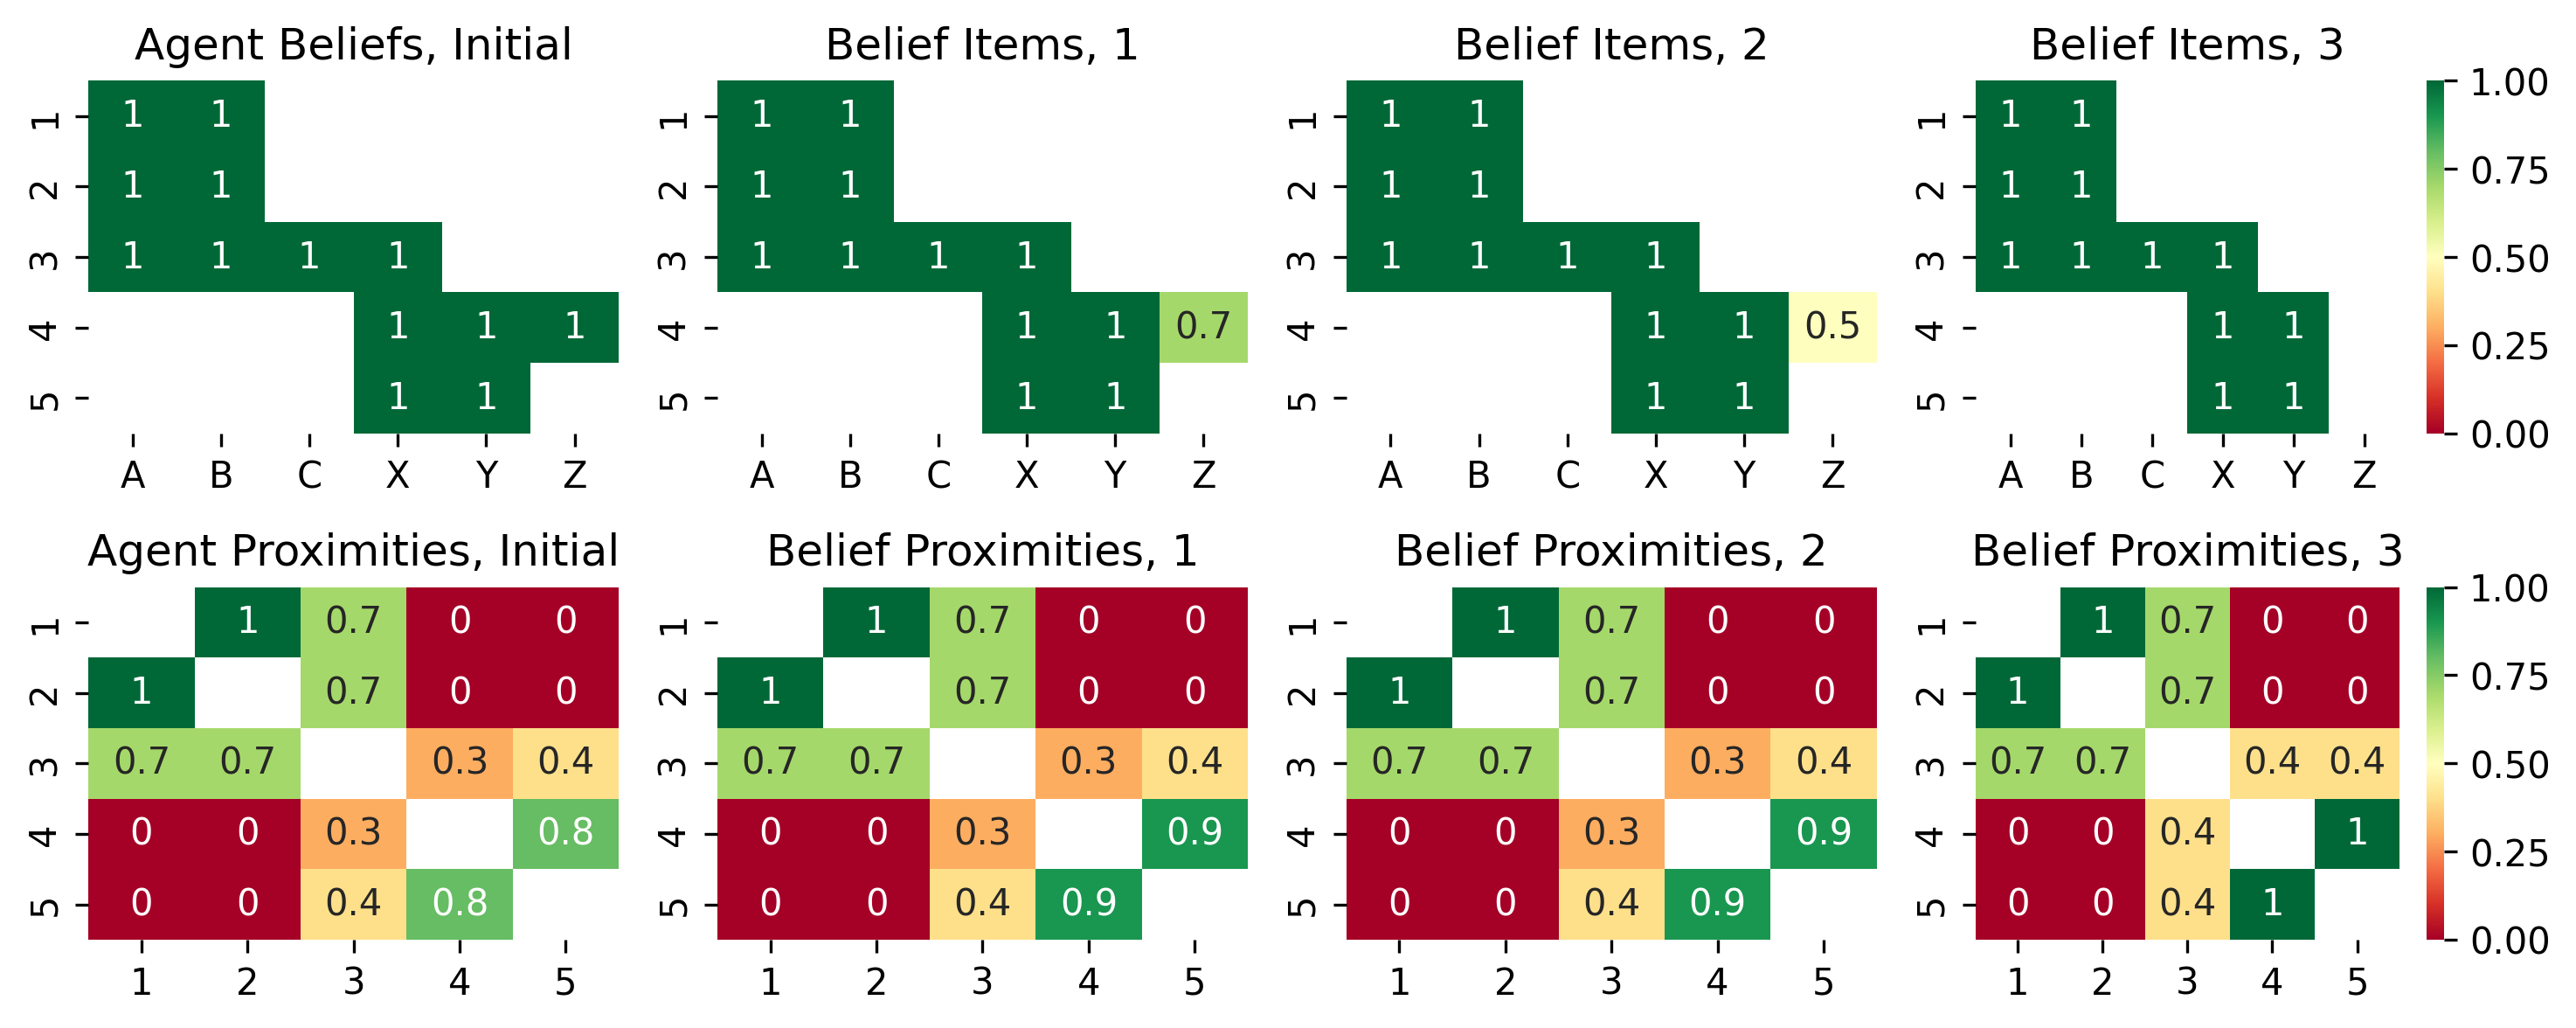

In [86]:
# socially closed, conservative belief => social stability, high diversity    
experiment_with_plots(recalc_proximities=True, peer_threshold = 0.5, forgetting_threshold = 0.5, printout = False)


Start 0.39
1 {'A': 1.0, 'B': 1.0}
2 {'A': 1.0, 'B': 1.0}
3 {'A': 1.0, 'B': 1.0, 'C': 1.0, 'X': 1.0}
4 {'X': 1.0, 'Y': 1.0, 'Z': 1.0}
5 {'X': 1.0, 'Y': 1.0}
1 {'A': 0.58, 'B': 0.58, 'X': 0.74, 'Y': 0.56}
2 {'A': 0.58, 'B': 0.58, 'X': 0.74, 'Y': 0.56}
3 {'A': 0.53, 'B': 0.53, 'C': 0.53, 'X': 1.0, 'Y': 0.62}
4 {'X': 1.0, 'Y': 1.0, 'Z': 0.73}
5 {'X': 1.0, 'Y': 1.0}
0.8
1 {'A': 0.49, 'B': 0.49, 'X': 0.81, 'Y': 0.62}
2 {'A': 0.49, 'B': 0.49, 'X': 0.81, 'Y': 0.62}
3 {'A': 0.49, 'B': 0.49, 'X': 0.82, 'Y': 0.62}
4 {'A': 0.46, 'B': 0.46, 'X': 0.82, 'Y': 0.65, 'Z': 0.54}
5 {'A': 0.47, 'B': 0.47, 'X': 0.82, 'Y': 0.64}
0.97
1 {'A': 0.49, 'B': 0.49, 'X': 0.81, 'Y': 0.62}
2 {'A': 0.49, 'B': 0.49, 'X': 0.81, 'Y': 0.62}
3 {'A': 0.49, 'B': 0.49, 'X': 0.81, 'Y': 0.62}
4 {'A': 0.49, 'B': 0.49, 'X': 0.81, 'Y': 0.63}
5 {'A': 0.49, 'B': 0.49, 'X': 0.81, 'Y': 0.63}
1.0


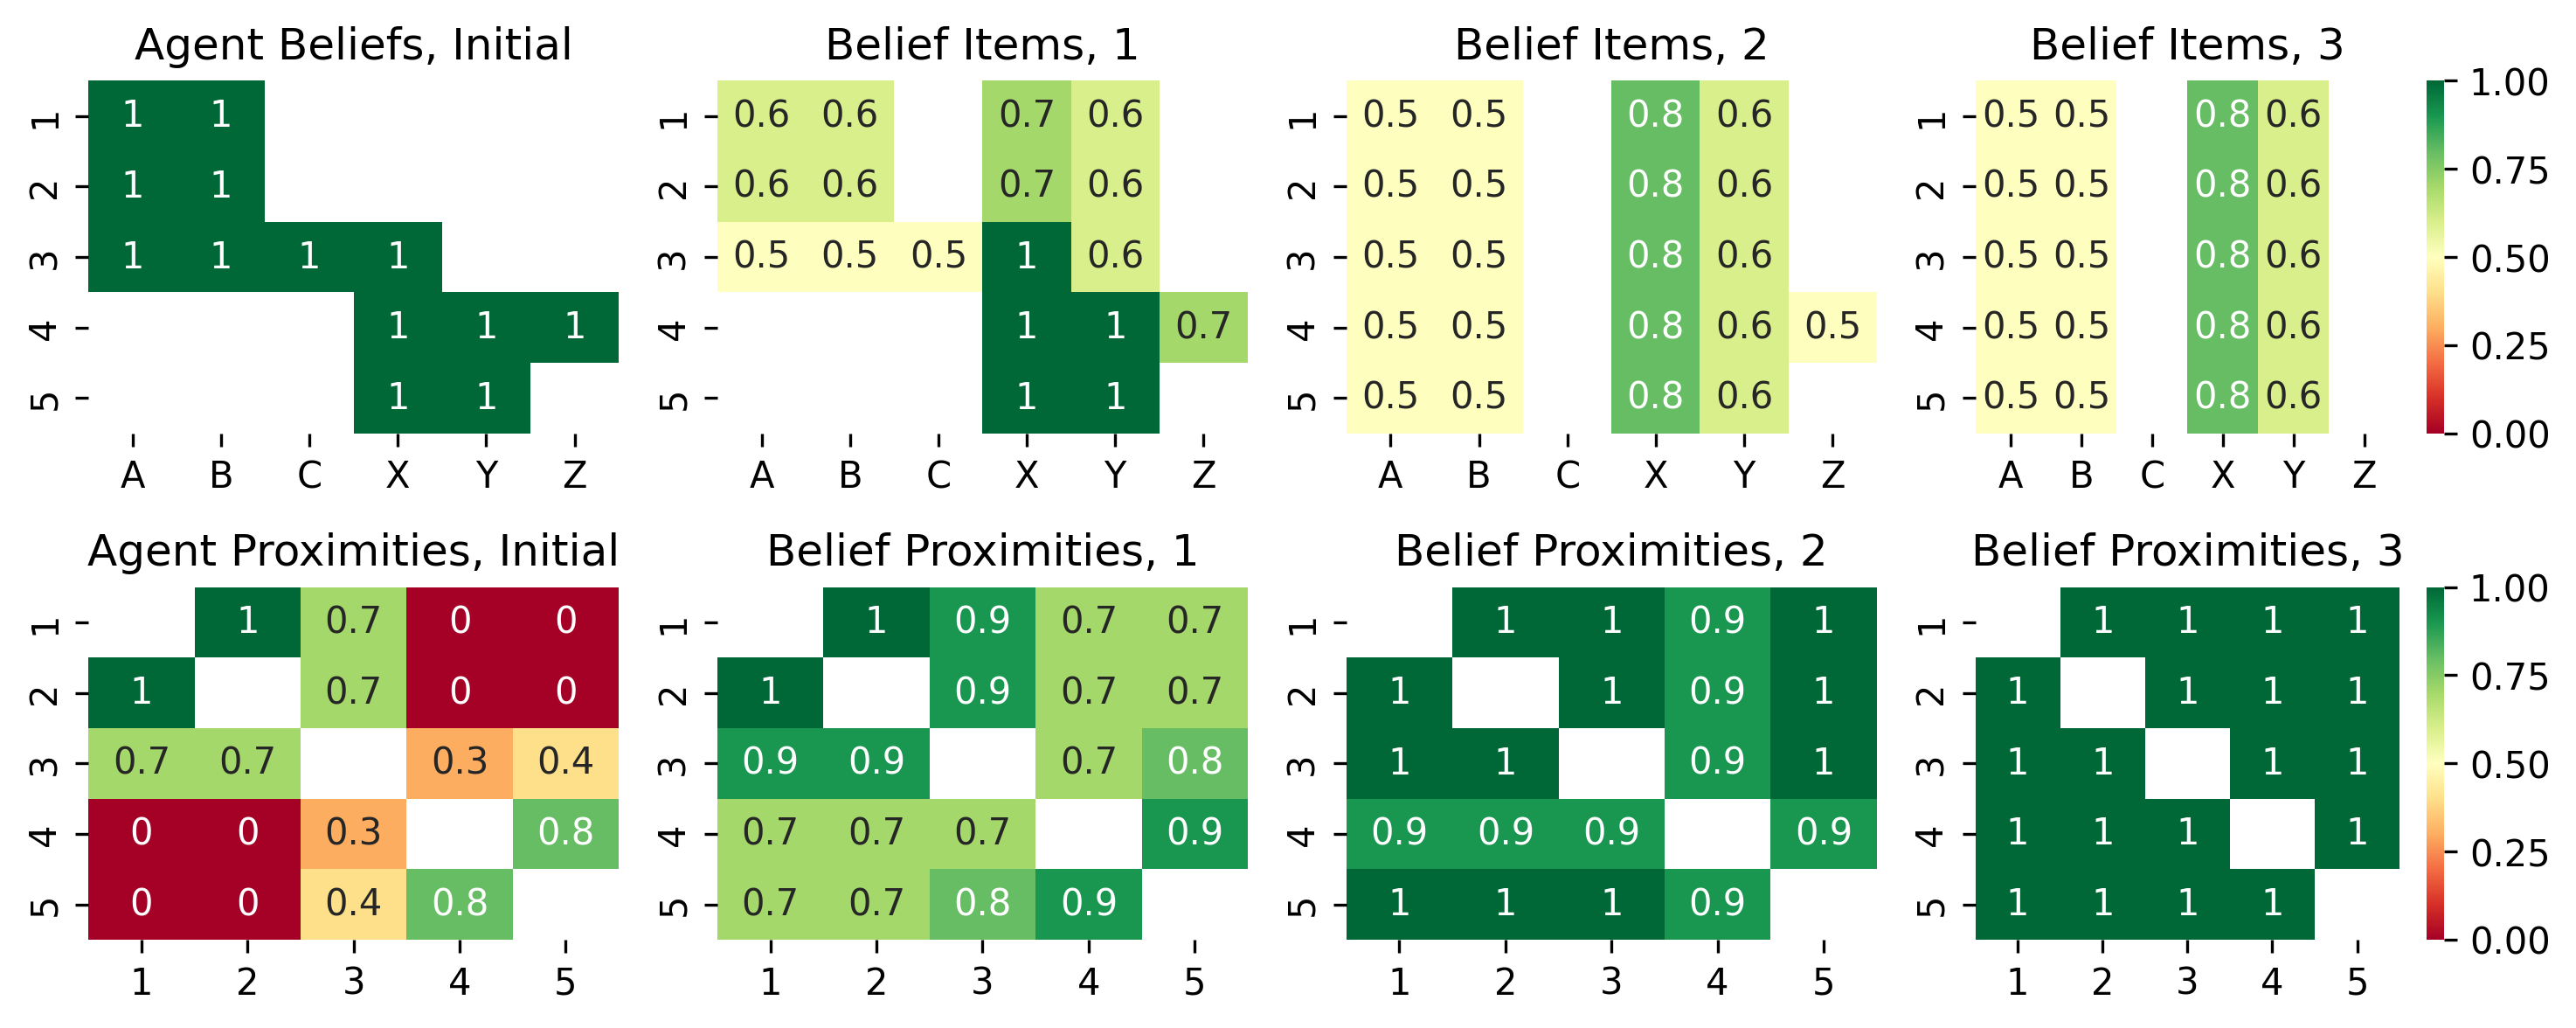

In [87]:
# socially open, conservative belief => consensus on commonvalues, disregaring diversity    
experiment_with_plots(recalc_proximities=True, peer_threshold = 0.0, forgetting_threshold = 0.5, printout = False)


In [ ]:
# TODO order impact